/home/julita/anaconda3/envs/anote/lib/python3.12/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


📉 ARI przed aktywnym uczeniem: 0.1222


 54%|█████▍    | 501/930 [01:25<01:13,  5.80it/s]

{'loss': 0.2094, 'grad_norm': 3.299222230911255, 'learning_rate': 9.312977099236641e-06, 'epoch': 1.61}


100%|██████████| 930/930 [02:37<00:00,  5.91it/s]


{'train_runtime': 157.2661, 'train_samples_per_second': 94.426, 'train_steps_per_second': 5.914, 'train_loss': 0.12082891464233399, 'epoch': 3.0}
✅ ARI po aktywnym uczeniu: 0.3089


/home/julita/anaconda3/envs/anote/lib/python3.12/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


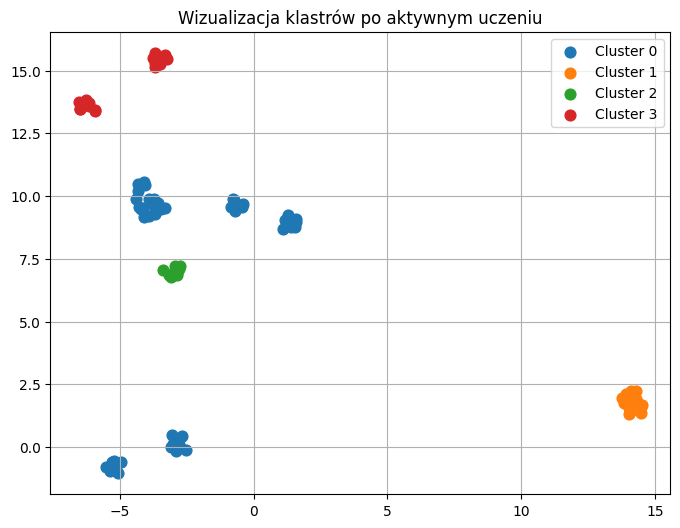

In [40]:
import pandas as pd
import numpy as np
from sentence_transformers import SentenceTransformer, InputExample, losses
from torch.utils.data import DataLoader
from sklearn.cluster import KMeans
from sklearn.metrics import adjusted_rand_score
import umap
import matplotlib.pyplot as plt

# 1. Wczytaj dane
df = pd.read_csv('../Adata/yahoo/train_subset.csv')
df = df.sample(n=100, random_state=42).reset_index(drop=True)
texts = df['text'].tolist()
labels = df['label'].tolist()

# 2. Użyj Sentence-BERT do embeddingów (przed trenowaniem)
base_model = SentenceTransformer('all-MiniLM-L6-v2')
embeddings_before = base_model.encode(texts)

# 3. Klasteryzacja + ARI przed trenowaniem
umap_model = umap.UMAP(n_neighbors=15, min_dist=0.1, n_components=30, random_state=42)
X_reduced_before = umap_model.fit_transform(embeddings_before)
kmeans = KMeans(n_clusters=4, random_state=42)
pred_labels_before = kmeans.fit_predict(X_reduced_before)
ari_before = adjusted_rand_score(labels, pred_labels_before)
print(f"📉 ARI przed aktywnym uczeniem: {ari_before:.4f}")

# 4. Tworzenie par: similar (label==label), different (label!=label)
examples = []
for i in range(len(texts)):
    for j in range(i+1, len(texts)):
        label = 1.0 if labels[i] == labels[j] else 0.0
        examples.append(InputExample(texts=[texts[i], texts[j]], label=label))

# 5. Fine-tuning SentenceTransformer
model = SentenceTransformer('all-MiniLM-L6-v2')  # kopia modelu
train_dataloader = DataLoader(examples, shuffle=True, batch_size=16)
train_loss = losses.OnlineContrastiveLoss(model=model)

model.fit(
    train_objectives=[(train_dataloader, train_loss)],
    epochs=3,
    warmup_steps=10,
    show_progress_bar=True
)

# 6. Embeddingi po trenowaniu
embeddings_after = model.encode(texts)
X_reduced_after = umap_model.fit_transform(embeddings_after)
pred_labels_after = kmeans.fit_predict(X_reduced_after)
ari_after = adjusted_rand_score(labels, pred_labels_after)
print(f"✅ ARI po aktywnym uczeniu: {ari_after:.4f}")

# 7. Wizualizacja 2D po trenowaniu
umap_2d = umap.UMAP(n_components=2, random_state=42)
X_2d = umap_2d.fit_transform(embeddings_after)

plt.figure(figsize=(8, 6))
for cluster_id in range(4):
    idx = np.where(np.array(pred_labels_after) == cluster_id)
    plt.scatter(X_2d[idx, 0], X_2d[idx, 1], label=f'Cluster {cluster_id}', s=60)

plt.title("Wizualizacja klastrów po aktywnym uczeniu")
plt.legend()
plt.grid(True)
plt.show()


In [11]:
model.save("fine_tuned_model")

In [13]:
# Załaduj testowy zbiór
from sentence_transformers import SentenceTransformer
model = SentenceTransformer("fine_tuned_model")

df_test = pd.read_csv('../Adata/ag_news/train_subset.csv')[:200]
texts_test = df_test['text'].tolist()
labels_test = df_test['label'].tolist()

# Wczytaj wytrenowany model
model = SentenceTransformer("fine_tuned_model")

# Oblicz embeddingi
embeddings_test = model.encode(texts_test)

# Klasteryzacja + ocena
umap_model = umap.UMAP(n_neighbors=15, min_dist=0.1, n_components=30, random_state=42)
X_reduced_test = umap_model.fit_transform(embeddings_test)

kmeans = KMeans(n_clusters=4, random_state=42)
predicted_test = kmeans.fit_predict(X_reduced_test)

# Ocena
from sklearn.metrics import adjusted_rand_score
ari_test = adjusted_rand_score(labels_test, predicted_test)
print(f"🧪 ARI na nowym zbiorze testowym: {ari_test:.4f}")


/home/julita/anaconda3/envs/anote/lib/python3.12/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


🧪 ARI na nowym zbiorze testowym: 0.7547


/home/julita/anaconda3/envs/anote/lib/python3.12/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


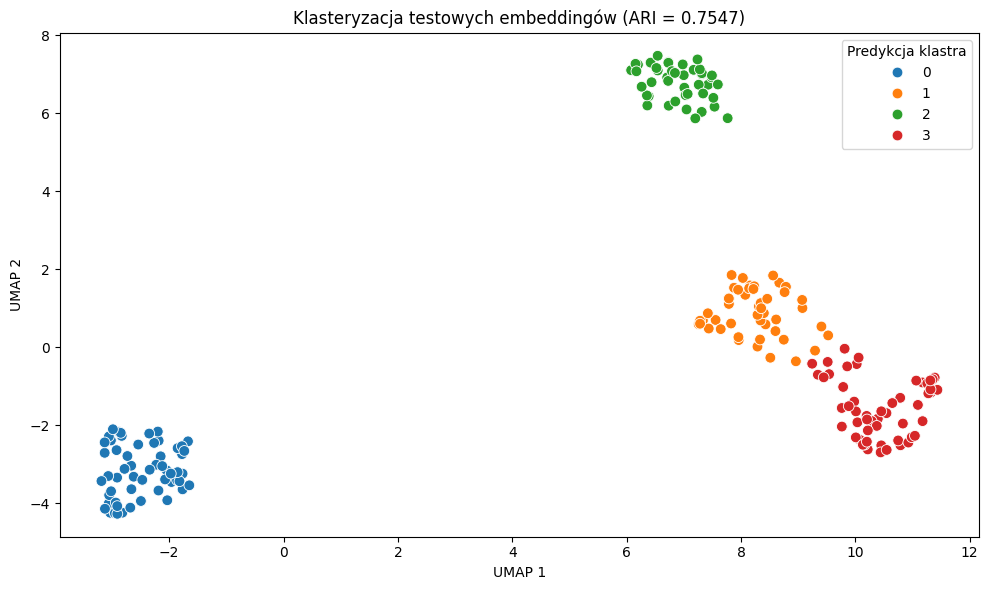

In [14]:
import matplotlib.pyplot as plt
import seaborn as sns
import umap
from sklearn.cluster import KMeans
from sklearn.metrics import adjusted_rand_score

# Redukcja do 2D dla wizualizacji
umap_2d = umap.UMAP(n_neighbors=15, min_dist=0.1, n_components=2, random_state=42)
X_2d = umap_2d.fit_transform(embeddings_test)

# KMeans dla etykiet
kmeans = KMeans(n_clusters=4, random_state=42)
predicted_clusters = kmeans.fit_predict(X_2d)

# Wykres
plt.figure(figsize=(10, 6))
palette = sns.color_palette("tab10", 4)  # 4 klastry
sns.scatterplot(x=X_2d[:, 0], y=X_2d[:, 1], hue=predicted_clusters, palette=palette, s=60)
plt.title(f'Klasteryzacja testowych embeddingów (ARI = {ari_test:.4f})')
plt.xlabel('UMAP 1')
plt.ylabel('UMAP 2')
plt.legend(title='Predykcja klastra', loc='best')
plt.tight_layout()
plt.show()


In [37]:
import pandas as pd
import numpy as np
from sentence_transformers import SentenceTransformer
from sklearn.metrics.pairwise import cosine_distances
from sklearn.preprocessing import normalize
from sklearn.neighbors import NearestNeighbors
from sklearn.cluster import KMeans

# 1. Wczytaj dane (AG News - częściowo zaetykietowane)
df = pd.read_csv("../Adata/ag_news/train_subset.csv").reset_index(drop=True)
texts = df["text"].tolist()
labels = df["label"].tolist()

# 2. Wybierz część danych z etykietami (upewnij się, że każda klasa jest reprezentowana)
unique_labels = list(set(labels))
np.random.seed(42)

# dla każdej klasy wybierz losowo kilka przykładów
labeled_indices = []
for lbl in unique_labels:
    indices = [i for i, y in enumerate(labels) if y == lbl]
    sampled = np.random.choice(indices, size=max((5, 20)), replace=False)
    labeled_indices.extend(sampled)

labeled_mask = np.zeros(len(df), dtype=bool)
labeled_mask[labeled_indices] = True
unlabeled_mask = ~labeled_mask

texts_labeled = [texts[i] for i in range(len(df)) if labeled_mask[i]]
labels_labeled = [labels[i] for i in range(len(df)) if labeled_mask[i]]
texts_unlabeled = [texts[i] for i in range(len(df)) if unlabeled_mask[i]]

# 3. Embeddingi
model = SentenceTransformer("all-MiniLM-L6-v2")  # jeśli fine-tuned nie działa, użyj domyślnego
embeddings = model.encode(texts, convert_to_numpy=True)
embeddings = normalize(embeddings)

# 4. Wytrenuj KMeans na embeddingach tylko z danych zaetykietowanych
embeddings_labeled = embeddings[labeled_mask]
kmeans = KMeans(n_clusters=len(set(labels)), random_state=42)
kmeans.fit(embeddings_labeled)

# 5. Przypisz etykiety do całego zbioru (pseudo-labels na podstawie klastrów)
pseudo_labels = kmeans.predict(embeddings)

# 6. CA-EIZ: oblicz CSS + EIZ na podstawie pseudo-etykiet
css_scores = []
for i, emb in enumerate(embeddings):
    label_i = pseudo_labels[i]
    same_class = [j for j in range(len(pseudo_labels)) if pseudo_labels[j] == label_i and j != i]
    other_class = [j for j in range(len(pseudo_labels)) if pseudo_labels[j] != label_i]

    d_same = cosine_distances([emb], embeddings[same_class]).mean() if same_class else 0
    d_other = cosine_distances([emb], embeddings[other_class]).mean() if other_class else 0
    css = d_other - d_same
    css_scores.append(css)

# EIZ: liczba sąsiadów w promieniu epsilon
eps = 0.3
nbrs = NearestNeighbors(radius=eps, metric='cosine').fit(embeddings)
eiz_counts = np.array([len(nbrs.radius_neighbors([emb], return_distance=False)[0]) for emb in embeddings])

# Normalizacja metryk
def safe_normalize(arr):
    arr = np.array(arr)
    if np.all(arr == arr[0]):
        return np.zeros_like(arr)
    return (arr - arr.min()) / (arr.max() - arr.min())

css_norm = safe_normalize(css_scores)
eiz_norm = safe_normalize(eiz_counts)

# Finalny CA-EIZ score
alpha = 0.6
beta = 0.4
final_score = alpha * css_norm + beta * eiz_norm

# 7. Wybierz top-k przykładów
top_k = 30
top_indices = np.argsort(-final_score)[:top_k]
selected_df = df.iloc[top_indices].copy()
selected_df["CA_EIZ_score"] = final_score[top_indices]
selected_df["pseudo_label"] = np.array(pseudo_labels)[top_indices]
selected_df["CSS"] = np.array(css_scores)[top_indices]
selected_df["EIZ"] = np.array(eiz_counts)[top_indices]


In [39]:
selected_df

,label,text,CA_EIZ_score,pseudo_label,CSS,EIZ
371,Business,Stock Markets Fall as Oil Nears \$50 a Barrel ...,0.860416,0,0.160530,3
37,Business,"Stocks Drop on \$49 Oil, Slowing Economy US bl...",0.827430,0,0.149592,3
20,Business,"Stocks Drop on \$49 Oil, Slowing Economy NEW ...",0.818041,0,0.146478,3
892,Business,Fed Expected to Boost Rates Again The Federal ...,0.808806,0,0.143416,3
587,Business,Fed expected to deliver fifth quarter-point ra...,0.785140,0,0.135569,3
742,Business,US Fed set to serve up another small rate hike...,0.743198,0,0.121661,3
203,Business,Dollar Slumps After Weak U.S. Data NEW YORK (...,0.709077,0,0.154559,2
692,Business,"Dollar Slumps Broadly, More Losses Seen NEW Y...",0.693913,0,0.149531,2
118,Business,Oil Climbing Back Up After Supply Report LOND...,0.672294,0,0.142362,2
80,Business,Delta Pilots Vote to Accept 32.5 Percent Pay C...,0.668082,0,0.052541,4
